# Import and Plot using python 🐍

In [14]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime
import random
import pandas as pd
import altair as alt
import warnings

%matplotlib notebook

## Functions

In [4]:
def get_xy(index):
    '''Gets the time and values of a given index 
    and stores them in an array of appropriate size.
    The time is the first column and the data are the
    subsequent columns'''
    
    t = dh[index].x[0]
    y = np.transpose(dh[index].y[0])
    if len(np.shape(y)) == 1:
        data = np.zeros((np.shape(t)[0],2))
        data[:,1] = y
    else:
        data = np.zeros((np.shape(t)[0],np.shape(y)[1]+1))
        data[:,1:np.shape(y)[1]+1] = y
    data[:,0] = t
    return data

In [5]:
def unix_to_utc(unix_time_array):
    '''Takes array of tick labels in unix time
    and converts them into readable utc'''
    result = [None]*(len(unix_time_array))
    for i in range(len(unix_time_array)):
        result[i] = datetime.datetime.utcfromtimestamp(unix_time_array[i]
        ).strftime('%H:%M:%S')
    print("result type:",type(result))
    return result

In [6]:
def multi_plot(data, minX_arr, maxX_arr):
    '''Creates len(minX) number of plots with 6 subplots each
    with nicely formatted datetime xlabels'''
    
    for i in range(len(minX_arr)):
        
        fig = plt.figure(figsize=(8,6.5));

        ax1 = fig.add_subplot(6,1,1);
        ax2 = fig.add_subplot(6,1,2,sharex = ax1);
        ax3 = fig.add_subplot(6,1,3,sharex = ax1);
        ax4 = fig.add_subplot(6,1,4,sharex = ax1);
        ax5 = fig.add_subplot(6,1,5,sharex = ax1);
        ax6 = fig.add_subplot(6,1,6,sharex = ax1);
  
        ax2.set_prop_cycle('color', ['r', 'g', 'b'])   

        ax1.plot(data[0][:,0], data1[:,1:]);
        ax2.plot(data[1][:,0], data2[:,1:]);
        ax3.plot(data[2][:,0], data3[:,1:]);
        ax4.plot(data[3][:,0], data4[:,1:]);
        ax5.plot(data[4][:,0], data5[:,1:]);
        ax6.plot(data[5][:,0], data6[:,1:]);

        ax1.set_ylabel('$|\mathbf{B}_{o}| (nT)$')
        ax2.set_ylabel('$\mathbf{B}_{o} (nT)$')
        ax3.set_ylabel('$n_{e}\ (cm^{-3})$')
        ax4.set_ylabel('$T_{e}$ (eV)')
        ax5.set_ylabel('$n_{i}\ (cm^{-3})$')
        ax6.set_ylabel('$T_{i}$ (eV)')

        ax6.set_xlabel('Time (July 14, 2008)')

        for j in range(len(fig.axes)-1):
            plt.setp(fig.axes[j].get_xticklabels(), visible=False)

        for j in range(len(fig.axes)):
            fig.axes[j].set_xlim(minX[i], maxX[i])

        ax6.set_xticklabels(unix_to_utc(ax6.get_xticks()));

        plt.tight_layout()
        
    return
        

In [7]:
def my_kmeans(data, k):
    '''Implementation of a simple k-means clustering algorithm
    for 2 dimensional data'''
    
    #Initilize closest centroid matrix
    closest_cent = np.empty(len(data))
    
    #Initilize positon of centroids
    indices = random.sample(range(len(data)),k)
    centroids = data[indices,:]
    
    #Stopping condition initialization
    total_dist_prev = 2.0
    total_dist_current = 1.0
    
    while abs(total_dist_prev/total_dist_current) > 0.001:
        total_dist = 0;
        #Find closest centroid to each point
        for i in range(len(data)): #Data points
            dist = np.empty(k)
            dist = dist.tolist()
            for j in range(k): #Centroids
                dist[j] = ((data[i,0] - centroids[j,0]) ** 2) + ((data[i,1] - centroids[j,1]) ** 2)
            #Value i of closest_cent corresponds to the closest centroid of the ith data point
            closest_cent[i] = dist.index(np.min(dist))
        total_dist_prev = total_dist_current
        total_dist_current = np.nanmin(dist)
        
        #Find the new location of each centroid from the mean
        #of each data point grouped with that centroid
        for j in range(k):
            indices = [i for i, x in enumerate(closest_cent) if x == j]
            centroids[j,0] = np.mean([data[i,0] for i in indices])
            centroids[j,1] = np.mean([data[i,1] for i in indices])
        
    return closest_cent, centroids
    

In [8]:
def k_means(data, k):
    '''Implementation of simple k-means clustering algorithm
    for n dimensional data. Each row of data should be a 
    different dimension from which to figure out the euclidian distance.
    
    Returns closest_cent for which the ith entry is the number
    of the closest centroid to the ith data point and 
    centroids which contains the coordinates for each centroid'''
    
    #Initilaize clocest centroid matrix and distance counters
    closest_cent = np.empty(len(data))
    dist_prev = np.empty(len(data))
    dist_current = np.empty(len(data))
    
    #Initialize position of centroids
    indices = random.sample(range(len(data)),k)
    centroids = data[indices,:]
    
    #Stopping condition initialization
    total_dist_prev = 2.0
    total_dist_current = 1.0
    
    
    while abs((total_dist_current - total_dist_prev)/total_dist_current) > 0.1:
        total_dist = 0
        #Find closest centroid to each point
        for i in range(len(data)): #Data points
            dist = np.empty(k)
            dist = dist.tolist()
            dist_prev = np.empty(len(data))
            dist_current = np.empty(len(data))
            for j in range(k): #Centroids
                dist_sum = 0
                for l in range(np.shape(data)[1]): #Dimensions of data set
                    dist_sum = dist_sum + ((data[i,l] - centroids[j,l]) ** 2)
                dist[j] = dist_sum
                #Value i of closest_cent corresponds to the closest centroid of the ith data point
                closest_cent[i] = dist.index(np.nanmin(dist))
            dist_prev[i] = dist_current[i]
            dist_current[i] = np.nanmin(dist)
            
            #Find the new location of each centroid from the mean
            #of each data point grouped with that centroid
            for cluster_num in range(k): #Clusters
                indices = [ind for ind, x in enumerate(closest_cent) if x == cluster_num] 
                for dim in range(np.shape(data)[1]): #Dimensions of data set
                    centroids[j,dim] = np.mean([data[ind,dim] for ind in indices])
                    
        total_dist_prev = np.sum(dist_prev)
        total_dist_current = np.sum(dist_current)  
                
    return closest_cent, centroids
                

## Code 

In [9]:
file = '/Users/Nolan/Desktop/THEMIS-Analysis/TPLOT_save_file_THC_08-07-14.tplot'
f = scipy.io.readsav(file,python_dict=True)

In [10]:
dq = f['dq']
dh = dq['dh']

In [11]:
index1 = 41 ## Magnetic Field Mag
index2 = 31 ## Magnetic Field Vector
index3 = 74 ## Electron Density Burst
index4 = 75 ## Electron Temp Burst
index5 = 89 ## Ion Density Burst
index6 = 90 ## Ion Temp Burst

data1 = get_xy(index1)
data2 = get_xy(index2)
data3 = get_xy(index3)
data4 = get_xy(index4)
data5 = get_xy(index5)
data6 = get_xy(index6)

In [10]:
#To find names and indicies
#Remember that it's offset 1 from IDL !!

for i in range(len(dq)):
    print(i, dq[i][0])

0 b'thc_state_pos'
1 b'thc_state_vel'
2 b'thc_state_man'
3 b'thc_state_roi'
4 b'thc_state_spinras'
5 b'thc_state_spindec'
6 b'thc_state_spinalpha'
7 b'thc_state_spinbeta'
8 b'thc_state_spinper'
9 b'thc_state_spinphase'
10 b'thc_state_spinras_correction'
11 b'thc_state_spindec_correction'
12 b'thc_state_pos_gse'
13 b'thc_state_pos_gsm'
14 b'thc_state_vel_gse'
15 b'thc_state_vel_gsm'
16 b'thc_state_pos_sel'
17 b'thc_state_pos_sse'
18 b'thc_state_vel_sel'
19 b'thc_state_vel_sse'
20 b'thc_state_spinras_corrected'
21 b'thc_state_spindec_corrected'
22 b'thc_fgs_gse'
23 b'thc_fgs_gsm'
24 b'thc_fgs_dsl'
25 b'thc_fgl_gse'
26 b'thc_fgl_gsm'
27 b'thc_fgl_dsl'
28 b'thc_fgl_ssl'
29 b'thc_fgh_gse'
30 b'thc_fgh_gsm'
31 b'thc_fgh_dsl'
32 b'thc_fgh_ssl'
33 b'thc_fge_gse'
34 b'thc_fge_gsm'
35 b'thc_fge_dsl'
36 b'thc_fge_ssl'
37 b'thc_fgs_mag'
38 b'thc_fgs_fci_flh_fce'
39 b'thc_fgl_mag'
40 b'thc_fgl_fci_flh_fce'
41 b'thc_fgh_mag'
42 b'thc_fgh_fci_flh_fce'
43 b'thc_state_pos__sm'
44 b'thc__Rad'
45 b'thc__

## Multi-Plot 📈

result type: <class 'list'>
result type: <class 'list'>
result type: <class 'list'>
result type: <class 'list'>
result type: <class 'list'>
result type: <class 'list'>


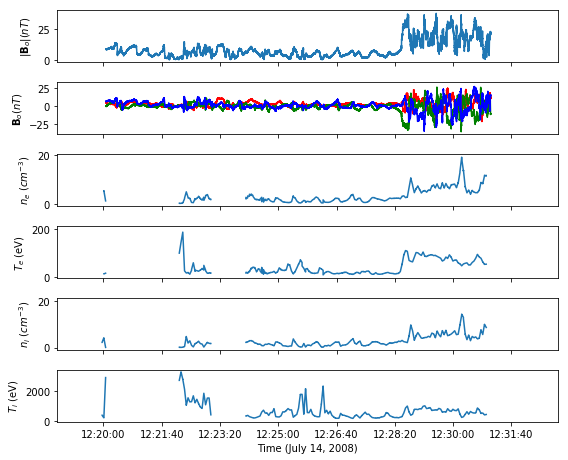

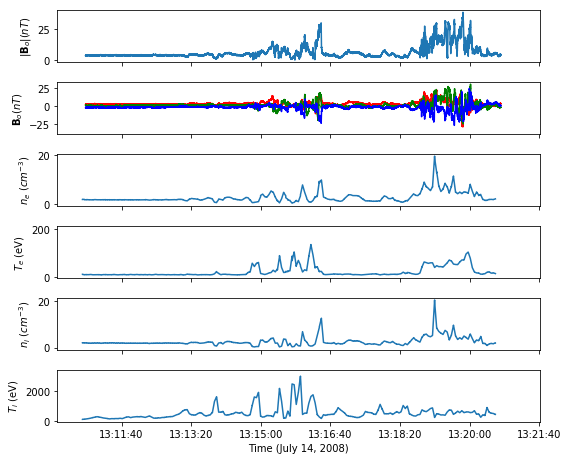

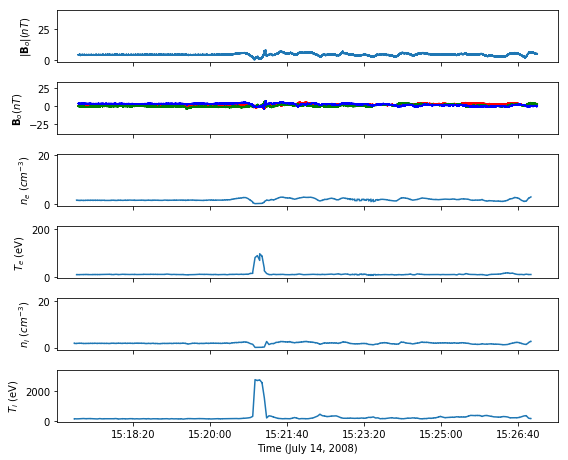

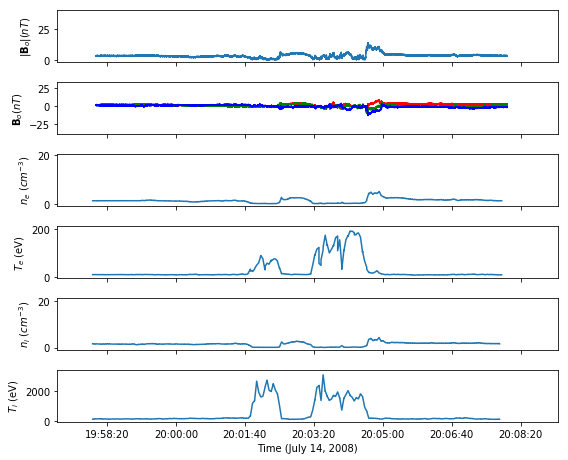

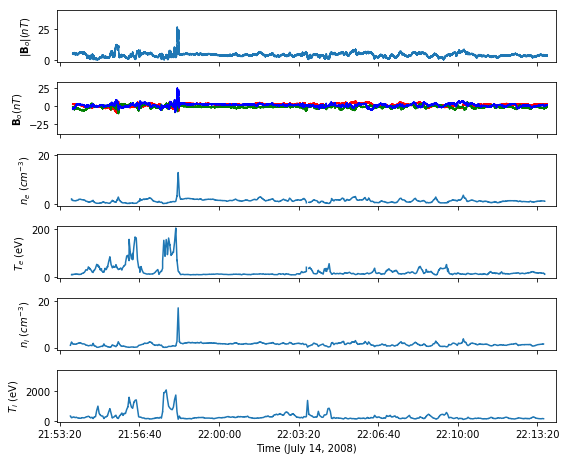

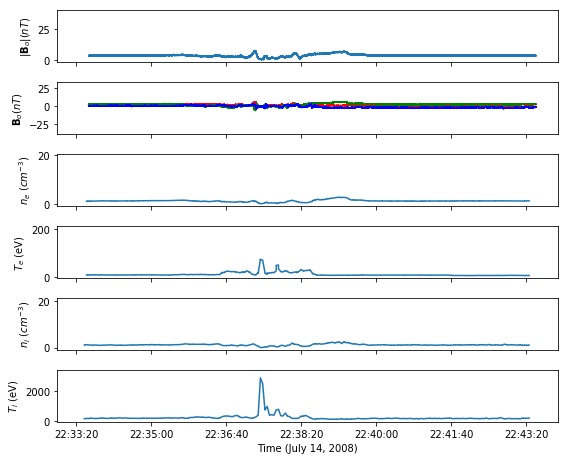

In [12]:
#These are the slices of interest for THEMIS C on July 14, 2008
minX = [1216037920.1924996,  1216041007.2713022, 1216048600.6996622,  1216065427.6443439, 
        1216072392.812362, 1216074774.0821779] 
maxX = [1216038780.2262125,  1216041700.6522138, 1216049251.4615242,  1216066154.194554, 
        1216073647.3888414, 1216075442.174325] 

data = [data1, data2, data3, data4, data5, data6]

multi_plot(data, minX, maxX)

# K-Means Algorithm

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


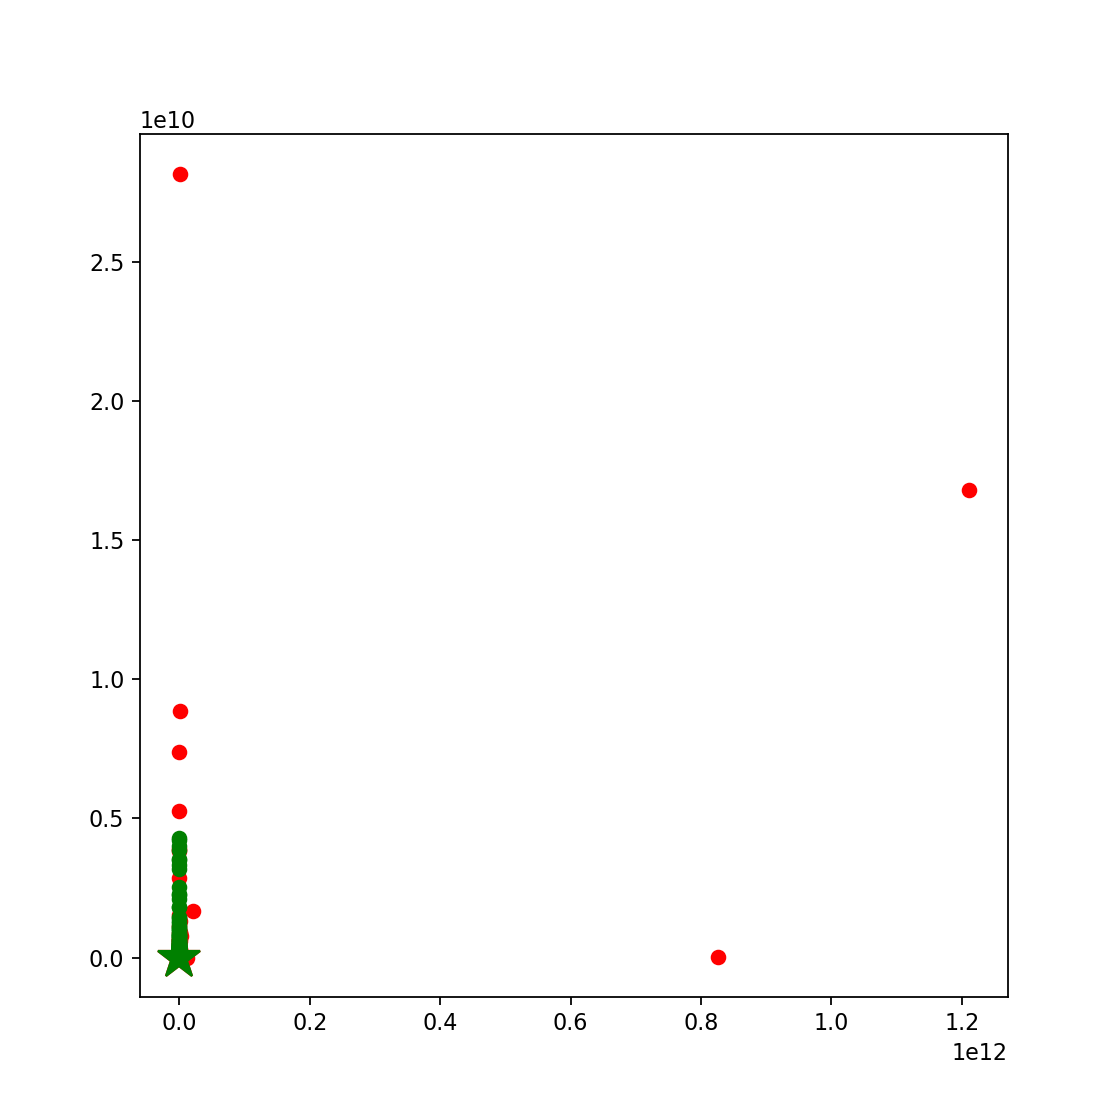

In [22]:
fit_A = get_xy(272)
fit_B = np.abs(get_xy(273))
fit_C = get_xy(274)

colorstr = 'rgbkc'

data = np.empty((len(fit_A),2))

data[:,0] = fit_A[:,1]
data[:,1] = fit_A[:,2]

#Get rid of NaN values
indices = [ind for ind, val in enumerate(data[:,1]) if ~np.isnan(val)]
data_clean = np.empty((len(indices),2))
data_clean[:,0] = data[indices,0] 
data_clean[:,1] = data[indices,1] 

k = 3

closest_cent, centroids = k_means(data_clean,k)

fig = plt.figure(figsize=(7,7))
plt.tight_layout()


for i in range(k):
    indices = [ind for ind, val in enumerate(closest_cent) if int(val) == i]
    #Plot points color-coded to their respective cluster
    plt.plot(data[indices,0], data[indices,1], colorstr[i], marker='o',linestyle='None')
    #Plot Centroids
    plt.plot(centroids[i,0], centroids[i,1], colorstr[i], marker='*', markersize='20')
    

# plt.plot(data[:,0], data[:,1], marker='o', linestyle='None')



/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


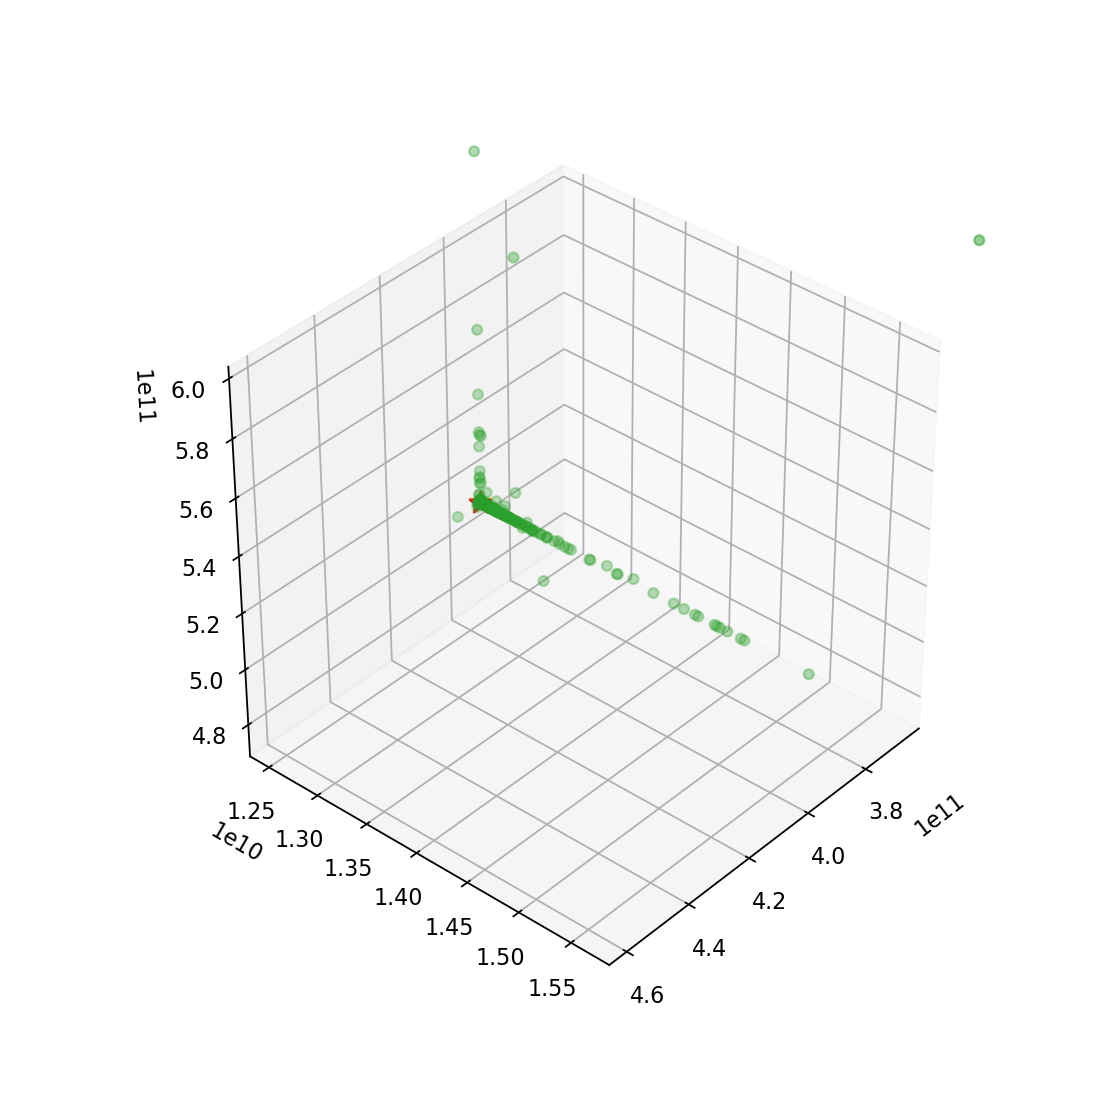

In [19]:
#TEST N DIMENSIONAL K MEANS ALGORITHM

fit_A = get_xy(272)

colorstr = 'rgbkc'

data = np.empty((len(fit_A),3))

data[:,0] = fit_A[:,1]
data[:,1] = fit_A[:,2]
data[:,2] = fit_A[:,3]

#Get rid of NaN values
indices = [ind for ind, val in enumerate(data[:,2]) if ~np.isnan(val)]
data_clean = np.empty((len(indices),3))
data_clean[:,0] = data[indices,0] 
data_clean[:,1] = data[indices,1] 
data_clean[:,2] = data[indices,2] 

k = 3
closest_cent, centroids = k_means(data_clean,k)

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

for i in range(k):
    indices = [ind for ind, val in enumerate(closest_cent) if int(val) == i]
    #Plot points color-coded to their respective cluster
    ax.scatter(data[indices,0], data[indices,1], data[indices,2],colorstr[i], marker='o',linestyle='None')
    #Plot Centroids
    ax.scatter(centroids[i,0], centroids[i,1],centroids[i,2], colorstr[i], marker='*', s=100)

In [ ]:
data = np.random.rand(100,3)

colorstr = 'rgbkc'

k = 3
closest_cent, centroids = k_means(data,k)

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

for i in range(k):
    indices = [ind for ind, val in enumerate(closest_cent) if int(val) == i]
    #Plot points color-coded to their respective cluster
    ax.scatter(data[indices,0], data[indices,1], data[indices,2],colorstr[i], marker='o',linestyle='None')
    #Plot Centroids
    ax.scatter(centroids[i,0], centroids[i,1],centroids[i,2], colorstr[i], marker='*', s=100)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
